<a href="https://colab.research.google.com/github/tsjannoun123-netizen/AI-for-Med.Diagnos.-Prediction-AAI_643O_O11_202610/blob/main/lesson2_Saera_Rawas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for practical exercises | Week #2 Lesson #2

## Introduction

This notebook contains practical hands-on exercises for the lesson about *Data visualization*.

After this session, you will know how to visualize and interprete a medical imaging dataset for training an AI model. We will implement and dissect four dimension reduction techniques which enables to better understand the data:
- Principal Component Analysis (PCA)
- t-distributed Stochastic Neighbor Embedding (t-SNE)
- Uniform Manifold Approximation and Projection (UMAP)
- Linear Discriminant Analysis (LDA)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import umap

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

## Dataset

We will re-use the features extracted at lesson #1. If you did not succeed in extracting these features, we provide you with a back-up.

### Download the backup

Run the following cells to download the backup.

<div class="alert alert-block alert-danger">
<b>Replace the <code>DATA_PATH</code> with the path where you want to store the data folder. By default, it will be stored at the root of this repository.</b> <br>
<b>If you already have the radiomic features, comment the following cell by adding a <code>#</code> before the <code>!</code></b>
</div>

In [5]:
DATA_PATH = '../..'

if not os.path.exists(f'{DATA_PATH}/data'):
    os.mkdir(f'{DATA_PATH}/data')

if not os.path.exists(f'{DATA_PATH}/data/ReMIND'):
    os.mkdir(f'{DATA_PATH}/data/ReMIND')

!curl https://uni-bonn.sciebo.de/s/eIHqHLT6dvsaSck/download --output {DATA_PATH}/data/ReMIND/radiomics_standardized.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  183k  100  183k    0     0   137k      0  0:00:01  0:00:01 --:--:--  137k


<div class="alert alert-block alert-info">
<b>Q1.</b> Load the standardized radiomic features in variable named <b>features</b>. Remove the columns containing the patient ID and the tumor label. Store the tumor label column in another variable named <b>labels</b>.
</div>

In [6]:
df = pd.read_csv(f'{DATA_PATH}/data/ReMIND/radiomics_standardized.csv')
features = df.drop(['patient', 'tumor'], axis=1)
labels = df['tumor']

In [ ]:
!

In [7]:
features.head()

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,0.860020,1.122862,1.396610,0.253136,0.830442,0.343751,0.356849,0.251977,0.471729,0.715953,...,-0.134040,-0.006542,0.587638,-0.229040,-0.301505,-0.181221,-0.331200,-0.111814,-0.408733,-0.158659
1,1.025073,0.507871,0.104606,-0.356884,-0.209951,-0.226259,-0.214213,-0.377701,-0.208317,0.018649,...,-0.173439,0.577784,-0.176907,-0.812217,-0.202383,-0.030719,-0.284125,-0.123831,-0.506981,-0.294942
2,-0.954156,-0.646563,-1.035618,-0.921583,-0.792979,-0.973916,-1.203671,-0.885273,-0.487601,-1.091582,...,-0.058062,-0.554663,0.508167,-0.219850,-0.376836,-0.430580,-0.202489,-0.115482,-0.482961,0.650141
3,1.339663,1.151933,-0.819872,-1.215635,-1.077766,-1.223924,-1.169485,-1.223477,-0.488464,-1.026820,...,-0.181980,0.602078,-1.079740,-0.226175,-0.378617,-0.318686,0.135175,-0.124402,-0.314173,-0.201749
4,-0.509357,-0.613268,-0.660474,-0.472525,-0.303654,-0.289065,-0.707875,-0.314526,-0.424301,-0.585267,...,0.000883,-0.556003,1.411481,0.678000,-0.384729,-0.423384,-0.291855,-0.070733,-0.298664,1.349813


## I. Principal Component Analysis (PCA)

The goal of the PCA is to find the directions (also called *"principal components"*) where the **data vary the most**.
- **Unsupervised**: does not use nor require class labels ;
- **Linear**: each principal component is a weighted combination of original features, orthogonal to others.

### How does it work?

1. Computes the covariance matrix of the data.
2. Finds eigenvectors (directions) and eigenvalues (amount of variance explained).
3. Projects the data onto the top-k components that explain the most variance.

### Pros/Cons

- Interest for variance rather than class separability ;
- Linear projection for modeling or pre-processing (can be used as feature extractor) ;
- Not useful if data is nonlinear or clusters overlap along directions of high variance.

### Implementation

We will start by computing the PCA with `n_components=2`, which means that we only want to compute the top-2 components that explain the most variance.

<div class="alert alert-block alert-info">
<b>Q2.</b> Visualize the results with the scatterplot. What can you say about the amount of variance between data?
</div>

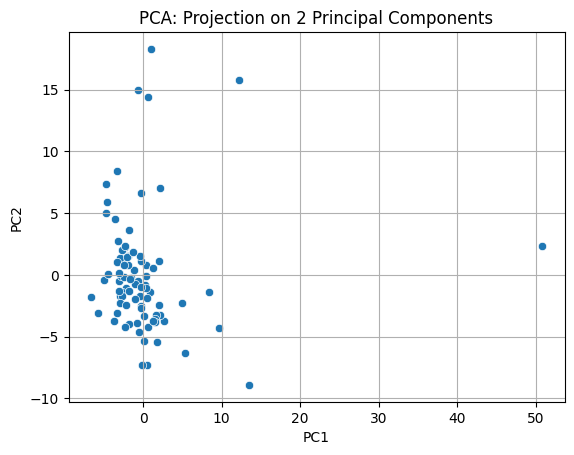

In [8]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features)

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1])
plt.title("PCA: Projection on 2 Principal Components")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

PC2 has more variance than PC1 along the y-axis.

You can label the points for better interpretability using the `hue` argument of the `scatterplot` function.

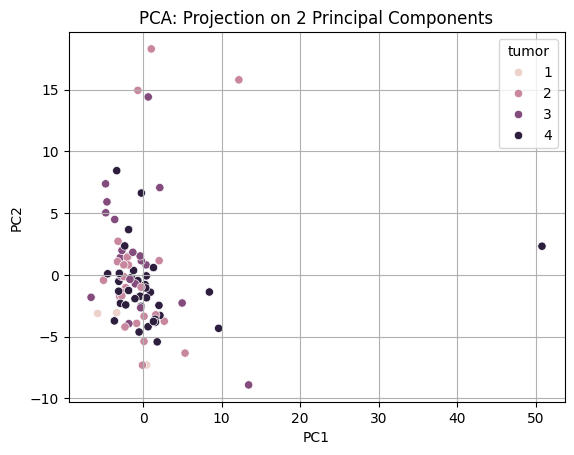

In [9]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features)

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels)
plt.title("PCA: Projection on 2 Principal Components")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

### Quantitative values

Besides plotting the components, you can also have a look at the values of the PCA.

First, you can look at the **explained variance ratio**, which tells you how much of the total variance is captured by each principal component.

In [10]:
# Explained variance per component
explained_var = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_var)

Explained variance ratio: [0.39119164 0.21299064]


You can also look at the **feature loadings**. These show how much each original feature contributes to each principal component.

In [11]:
# Get the loadings
loadings = pd.DataFrame(
    pca.components_.T,  # Transpose so rows are features
    columns=[f'PC{i+1}' for i in range(len(pca.components_))],
    index=features.columns
)

In [ ]:
# Show top contributing features for PC1
loadings['PC1'].sort_values(key=abs, ascending=False).head(10)

,PC1
original_firstorder_MeanAbsoluteDeviation,0.151448
original_firstorder_InterquartileRange,0.150695
original_firstorder_RobustMeanAbsoluteDeviation,0.150590
original_firstorder_90Percentile,0.150436
original_firstorder_Maximum,0.149062
original_firstorder_Range,0.148305
original_glcm_DifferenceAverage,0.147844
original_glrlm_LongRunHighGrayLevelEmphasis,0.144882
original_glrlm_HighGrayLevelRunEmphasis,0.144660
original_glrlm_ShortRunHighGrayLevelEmphasis,0.144534


In [12]:
# Show worst contributing features for PC1
loadings['PC1'].sort_values(key=abs, ascending=True).head(10)

,PC1
original_glrlm_LongRunEmphasis,-0.000013
original_glrlm_GrayLevelNonUniformity,-0.000152
original_firstorder_Skewness,-0.001420
original_glcm_Idmn,0.005185
original_glrlm_LowGrayLevelRunEmphasis,-0.005905
original_glrlm_RunVariance,0.007492
original_gldm_DependenceVariance,0.008173
original_glcm_Idn,0.009428
original_glszm_LargeAreaLowGrayLevelEmphasis,0.009530
original_gldm_SmallDependenceLowGrayLevelEmphasis,-0.011522


<div class="alert alert-block alert-info">
<b>Q3.</b> Analyse the results and answer the following questions:
    <br>
    - Are the features linearly separable?
    <br>
    - Does the tumor grade explain the largest amount of variance?
    <br>
    - Does the shape of the tumor does contribute to a large amount of variance?
</div>

Features are not linearly separable.

Tumor grade does not explain the largest variance.

Tumor shape does not contribute strongly to PC1; instead, texture features dominate.

## II. T-distributed Stochastic Neighbor Embedding (t-SNE)

t-SNE emphasizes local structure by keeping similar points close. This technique is highly useful for exploring clusters.
- **Nonlinear**
- **Unsupervised**

### How does it work?
1. Converts pairwise distances into probabilities that measure similarity ;
2. Tries to minimize the difference between high- and low-dimensional similarities ;
3. Uses perplexity as a smoothing parameter (number of neighbors).

### Pros/Cons
- Results cannot be interpreted quantitatively (distances are not reliable) ;
- Sensitive to perplexity and random seed — unstable with noise or outliers ;
- Useful for data exploration, not for data modelling.

### Implementation

In [13]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(features)

<div class="alert alert-block alert-info">
<b>Q4.</b> Plot the results, similarly to what we have done for the PCA and explore similarity across tumor grades.
</div>

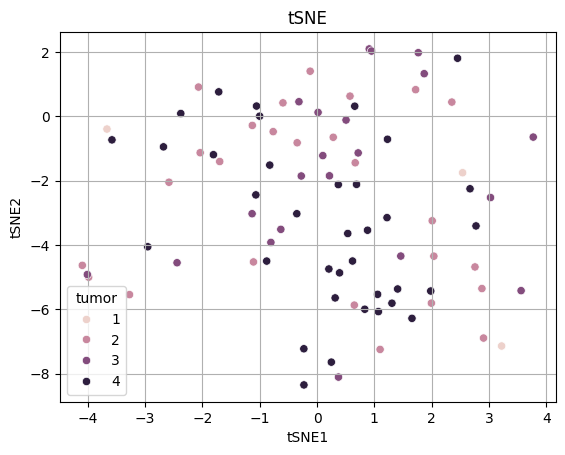

In [14]:
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=labels)
plt.title("tSNE")
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")
plt.grid(True)
plt.show()

<div class="alert alert-block alert-info">
<b>Q5.</b> Modify the parameters of the tSNE (perplexity, random state) and compare the results. Discuss the reproducibility and sensitivity of the algorighm.
</div>

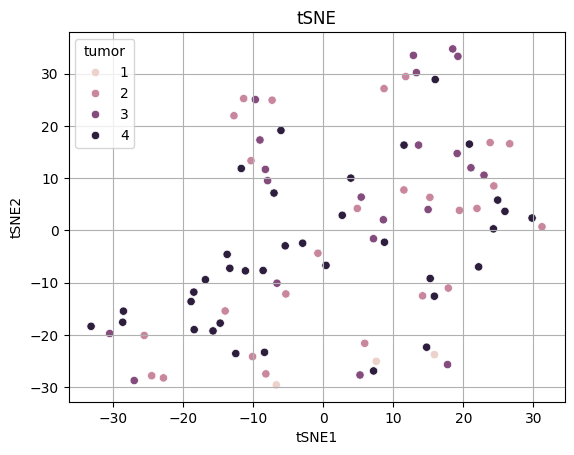

In [15]:
tsne = TSNE(n_components=2, perplexity=5, random_state=35)
X_tsne = tsne.fit_transform(features)

sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=labels)
plt.title("tSNE")
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")
plt.grid(True)
plt.show()

## III. Uniform Manifold Approximation and Projection (UMAP)

UMAP balances local and global structure in data. It constructs a high dimensional graph representation of the data then optimizes a low-dimensional graph to be as structurally similar as possible.
- **Nonlinear**
- **Unsupervised**

Have a look at this interactive website about the difference between UMAP and tSNE:
[https://pair-code.github.io/understanding-umap/](https://pair-code.github.io/understanding-umap/).

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


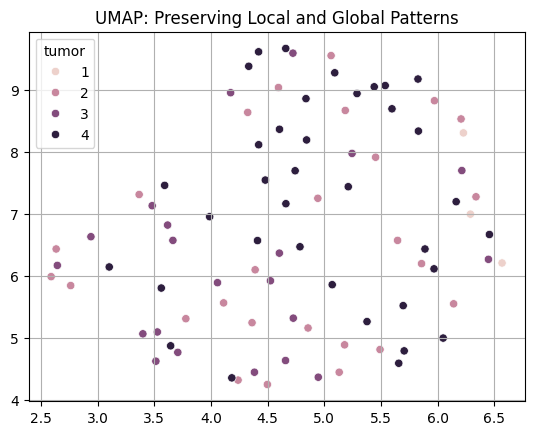

In [16]:
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(features)

sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=labels)
plt.title("UMAP: Preserving Local and Global Patterns")
plt.grid(True)
plt.show()

<div class="alert alert-block alert-info">
<b>Q6.</b> Visualize the features color-coded by tumor grade. Compare with the previous visualization and hypothesize on the variance and separability of features.
</div>

## IV. Linear Discriminant Analysis (LDA)

LDA finds directions that best separate known classes.
- **Supervised**: uses label Y to find discriminant axes
- **Linear**

### How does it work?
1. Calculates between-class and within-class scatter ;
2. Maximizes the ratio of between-class to within-class variance ;
3. Finds axes (discriminants) that maximize class separation.

### Pros/Cons
- Requires to have access to class labels.
- If the data have too many classes vs. too few samples, LDA can overfit.
- Nonlinear class separation — LDA can miss curved or nested boundaries.
- Classes must be reasonably normally distributed with equal covariance.

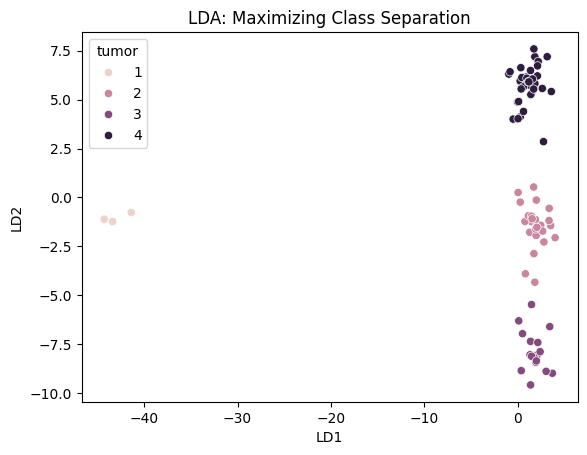

In [17]:
lda = LDA(n_components=2)
X_lda = lda.fit_transform(features, labels)

sns.scatterplot(x=X_lda[:,0], y=X_lda[:,1], hue=labels)
plt.title("LDA: Maximizing Class Separation")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.grid(False)
plt.show()

Similar to PCA, we can explore quantitative parameters of the LDA.

Each linear discriminant (LD1, LD2, etc.) represents a direction that separates the classes. You can check how much class separation each one contributes. Explained variance ratio, in that case, will tell you how much of the total class-discriminating power is captured by each axis.

<div class="alert alert-block alert-info">
<b>Q7.</b> Print the <b>explained variance ratio</b> of the LDA. How does it compare to the one obtained with PCA?
</div>

In [18]:
# Explained variance ratio
print(lda.explained_variance_ratio_)

[0.63288743 0.2807598 ]


<div class="alert alert-block alert-info">
<b>Q8.</b> Using the code below, complete and visualize the most important features to separate classes. These are stored in the attribute <b>coef_</b>. <br>
Compare with the ones obtained with PCA.
</div>

In [19]:
# Get the loadings
coefficients = pd.DataFrame(
    lda.coef_.T,  # COMPLETE with transposed coefficients
    columns=[f'LD{i+1}' for i in range(len(lda.classes_))], # COMPLETE with numbers of LD
    index=features.columns
)

In [20]:
coefficients['LD1'].sort_values(key=abs, ascending=False).head(10)

,LD1
original_glszm_HighGrayLevelZoneEmphasis,14047.181767
original_glrlm_RunLengthNonUniformityNormalized,11630.706403
original_gldm_LowGrayLevelEmphasis,-11446.172461
original_gldm_LargeDependenceLowGrayLevelEmphasis,10830.108446
original_glszm_SmallAreaHighGrayLevelEmphasis,8984.937524
original_glcm_JointEntropy,-8500.573130
original_glszm_GrayLevelVariance,-7810.295447
original_glrlm_ShortRunEmphasis,-7731.932031
original_glrlm_LongRunHighGrayLevelEmphasis,-5421.018459
original_glszm_LargeAreaEmphasis,5119.230398


<div class="alert alert-block alert-info">
<b>Q9.</b> Overall, which visualization strategy gave you the largest amount of information on the dataset? What can you conclude?
</div>

The Linear Discriminant Analysis gave us the best overview of the data through highlighting the main factors of variations across tumor classes.

## V. Out-of-sample mapping

Dimension reduction strategies are particularly useful to visualize clusters / groups of points in the dataset. When a new sample comes out, we can also use these techniques to compare this sample to the others: *e.g.*, if this sample is close to other samples from a particular class, we can suppose that it belongs to this class.

<div class="alert alert-block alert-info">
<b>Q10.</b> Given the features of a new sample below, use the <b>transform</b> function from the <b>lda</b> variable to compute the values of the linear discriminants for this sample. Add this sample to the previous plot and hypothesize on the class of this new sample.
</div>

In [21]:
new_sample = [[ 1.26834163,  1.06519637,  0.35581886, -0.40428694, -0.22592274,
        -0.21538908, -0.19894005, -0.30840048, -0.29237031,  0.03156306,
        -1.03046226, -0.13122895,  0.01972289, -0.2939223 ,  0.76823103,
         0.18890958, -0.13079974,  0.8846071 , -0.02335545, -0.63297882,
        -0.05560648, -0.02177836,  0.45498866,  0.49332652, -0.29193337,
        -0.03531171, -0.0351121 ,  0.33731763, -0.99082835, -0.13445852,
        -0.93477499, -0.11254808,  0.00860319, -0.10487846, -0.10991895,
        -0.11511869, -0.09068093, -0.19177814,  0.36747709,  0.96626843,
        -0.10781029, -1.13306325, -1.16947488, -0.10713231, -0.49413587,
         0.88910261, -0.26019065, -0.89344071,  0.6647477 , -0.58359377,
         1.03257508, -0.47075593, -0.70508202,  0.66034939,  0.83887402,
        -0.11654601,  0.46703375, -0.2495636 ,  0.86488433, -0.70132276,
        -0.38462811, -0.11742991,  0.00180459, -0.79520315,  0.36510164,
        -0.29583286, -0.41202009,  1.10673151, -0.0877228 , -0.62447257,
        -0.7080512 , -0.91838497, -0.11885765, -0.02021118, -0.42169212,
        -0.00341436, -0.24771799, -0.60542841,  0.4252188 , -0.2979829 ,
         1.14659038,  1.03979075, -0.33879935,  1.03731472, -0.02132954,
        -0.77676779, -0.14083675, -0.66600007, -0.12169235, -0.07525772,
        -0.38246718, -0.55088664, -0.20938972, -0.48735671, -0.17152936,
         0.54843396,  0.56775172, -0.0943027 , -0.52908346,  0.40415871,
         1.0792584 , -0.37506485, -0.38651042, -0.24627587, -0.11221304,
         0.10279348, -0.27811461]]

In [24]:
X_new_lda = lda.transform(new_sample) # COMPLETE with the correct function

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(


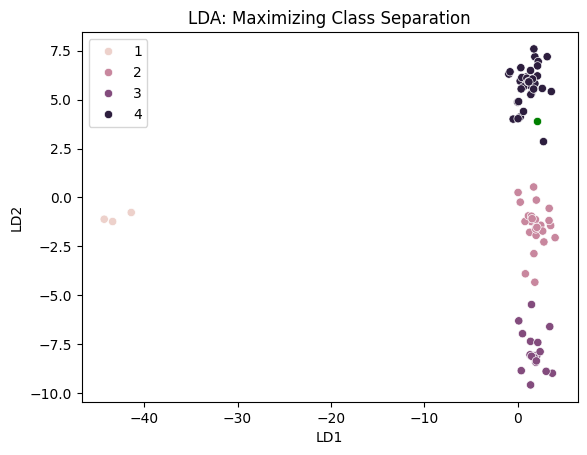

In [26]:
sns.scatterplot(x=X_lda[:,0], y=X_lda[:,1], hue=labels) # COMPLETE to plot samples used to fit the model
sns.scatterplot(x=X_new_lda[:,0], y=X_new_lda[:,1], color='green') # COMPLETE to plot new samples
plt.title("LDA: Maximizing Class Separation")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.grid(False)
plt.show()